## In this notebook, we'll shift the focus of the meta-analysis and look at the difference between healthy controls from the collection of studies, based on age, sex and location metadata (when available)

In [22]:
from utils import qiime_to_dataframe, clr, filter_taxa, mwstats, kwtests
import pandas as pd
import qiime2 as q2
import biom
from plotnine import *
from plotnine3d import *
import skbio
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
import os
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


%matplotlib inline

All the metadata files were updated to include geographic information, by both continent and country. By loading all the metadata files, we can see which locations are include in both oropharynx and nasopharynx samples. 

In [2]:
os.chdir('/proj/gibbons/nbohmann/metabug/manifest/NP/metadata/')
regions = []

for file in os.listdir():
    df = pd.read_csv(file, sep = '\t')
    regions.append(df.country.unique()[0])
regions

['France',
 'Netherlands',
 'USA',
 'Belgium',
 'Kenya',
 'Chile',
 'Australia',
 'Brazil',
 'Netherlands',
 'China',
 'China',
 'China',
 'USA',
 'Italy',
 'Netherlands',
 'USA',
 'Spain',
 'USA',
 'USA',
 'India',
 'Germany']

Now we'll load in all the qiime dataframes and merge with the corresponding metadata, concatinating each dataframe to produce a master dataframe with each datapoint included. 

In [3]:
collapse_on=["kingdom", "phylum", "class", "order", "family", "genus"]
os.chdir('/proj/gibbons/nbohmann/metabug/manifest/NP/')
manifest_NP = pd.read_csv('NP_manifest.csv',index_col= 0, header = None)
res = pd.DataFrame()
for file_name in manifest_NP.index:
    #pull out feature tables with total reads
    ab = qiime_to_dataframe(feature_table="qiime/"+file_name+"_table.qza",
                        taxonomy="qiime/"+file_name+"_taxonomy.qza", 
                        collapse_on=collapse_on) 
    #merge with metadata
    meta = pd.read_csv('metadata/'+file_name+'_metadata.tsv', sep="\t")
    meta.rename(columns={meta.columns[0]: "sample_id"}, inplace=True)
    ab = pd.merge(ab, meta, on="sample_id")
    ab['URT'] = 'NP'
    ab['Study'] = file_name
    #concatenate dataframes together
    res = pd.concat([res,ab])
os.chdir('/proj/gibbons/nbohmann/metabug/manifest/OP/')
manifest_OP = pd.read_csv('OP_manifest.csv',index_col= 0, header = None)
for file_name in manifest_OP.index:
    #pull out feature tables with total reads
    ab = qiime_to_dataframe(feature_table="qiime/"+file_name+"_table.qza",
                        taxonomy="qiime/"+file_name+"_taxonomy.qza", 
                        collapse_on=collapse_on) 
    #merge with metadata
    meta = pd.read_csv('metadata/'+file_name+'_metadata.tsv', sep="\t")
    meta.rename(columns={meta.columns[0]: "sample_id"}, inplace=True)
    ab = pd.merge(ab, meta, on="sample_id")
    ab['URT'] = 'OP'
    ab['Study'] = file_name
    #concatenate dataframes together
    res = pd.concat([res,ab])
res = res.dropna(subset = ['genus']) #filter data 
res = res[res.condition == 'control'] #filter to just controls
res = res[~(res.genus.str.contains('None'))&~(res.genus.str.contains('uncultured'))&~(res.genus.str.contains('Chloroplast'))]
res_sex = res[~pd.isnull(res.sex)] #res_sex has all samples with sex metadata
res_sex = clr(filter_taxa(res_sex, min_reads=2, min_prevalence=0.05)) #center-log-ratio transformation and filtering
res_age = res[~pd.isnull(res.age)] #res_age has all samples with age metadata
res_age = clr(filter_taxa(res_age, min_reads=2, min_prevalence=0.05)) #center-log-ratio transformation and filtering
res_metadata = res[~(pd.isnull(res.age))&~pd.isnull(res.sex)]
res_metadata = clr(filter_taxa(res_metadata,min_reads = 2, min_prevalence = 0.5))
res = clr(filter_taxa(res, min_reads=2, min_prevalence=0.5)) #center-log-ratio transformation and filtering

## Geographic location

For location, we'll run a Kruskal-Wallis to look for taxa significantly enriched between locations. First, we'll look at the distribution of samples from different regions. 

In [ ]:
(ggplot(res, aes(x = 'region')) + geom_histogram(aes(fill = 'region'), binwidth = 0.5) 
+ labs(x = 'Region', y= 'Count', fill = 'Region'))

Now we'll use Kruskal-Wallis test to determine if the distribution of genus abundances seems to be sampled from the same population.

In [ ]:
collapse_on=["kingdom", "phylum", "class", "order", "family", "genus"]
collapsed = res.groupby(collapse_on)
results = kwtests(collapsed,'region')
for_plots = res[res['genus'].isin(results[results['q']<0.05]['taxon'])].groupby(
    ["kingdom", "phylum", "class", "order", "family","genus","region"]).mean().reset_index()
to_drop = for_plots.groupby(collapse_on)['relative'].mean()[for_plots.
            groupby(collapse_on)['relative'].mean()<0.01].reset_index()['genus']
for_plots = for_plots[~for_plots['genus'].isin(to_drop)]
for_plots.genus = for_plots.genus.str.split('_').str[0]
for_plots.genus = for_plots.genus.str.split('-').str[0]
for_plots = pd.pivot_table(for_plots, index = 'genus', columns = 'region', values = 'clr').fillna(0.0)
for_plots

In [ ]:
import scikit_posthocs
result = pd.DataFrame()
for genus in res['genus'].unique():
    dunn = scikit_posthocs.posthoc_dunn(res[res['genus']==genus], val_col = 'clr', group_col = 'region')
    indices, columns = np.where(dunn.lt(0.05))
    pairs = list(zip(indices,columns))
    pairs_labels = pd.DataFrame([(dunn.index[i], dunn.columns[j]) for i,j in pairs])
    pairs_labels['taxon'] = genus
    result = pd.concat([result,pairs_labels])

To visualize our significant associations, we'll build a heatmap in Seaborn 

In [ ]:
fig, ax = plt.subplots(nrows=1,
                               figsize=(14, 7))

sns.set(font_scale=1)
sns.heatmap(for_plots.T,
                    cmap=sns.diverging_palette(240,20,center='light',as_cmap=True),
                    ax = ax
                    )

font_props = FontProperties().copy()
font_props.set_size(15)

ax.set_yticklabels(ax.get_ymajorticklabels(), fontproperties=font_props)
font_props.set_style("italic")
ax.set_xticklabels(ax.get_xmajorticklabels(), fontproperties=font_props)


plt.yticks(rotation=0)
plt.tight_layout()


## Sex
As sex is included as a binary variable, we will use classic Mann-Whitney to determine significant enrichments between male and female study participants

In [ ]:
(ggplot(res_sex, aes(x = 'sex')) + geom_histogram(aes(fill = 'sex'), binwidth = 0.2) 
+ labs(x = 'Sex', y = 'Count', fill = 'Sex'))

Next, we'll apply a Mann-Whitney test to check for significant differences in genus abundance between sexes. 

In [ ]:
collapse_on=["kingdom", "phylum", "class", "order", "family", "genus"]
results = (
        res_sex.groupby(collapse_on)
        .apply(
            lambda df: mwstats(
               df.clr[df['sex'] == 'M'],
                df.clr[df['sex'] != 'M'],
            )
        )
        .reset_index()
    )
results = results.dropna(subset = ['p'])
results["q"] = fdrcorrection(results.p)[1]
results.sort_values(by = 'q')

In [86]:
pval

0.4494541228814173

No significant hits were seen. 

## Age 

For age, as it is a continuous variable, we will have to take another approach, using quantiles. First we'll define the quantiles, then let's take a look at the distribution of ages included in healthy controls

In [109]:
results_age = pd.DataFrame()
res_age['age2'] = np.square(res_age['age'])
for taxon in res_age['genus'].unique():
    temp = res_age[res_age['genus'].str.startswith(taxon)]
    if min(temp.region.value_counts())<5: 
        temp = temp[~temp.region.str.contains(temp.region.value_counts()[temp.region.value_counts()<5].index[0])]
    md = smf.ols("clr ~ age + age2 + URT + region",temp)
    mdf = md.fit()
    pval = mdf.pvalues['age']
    pval2 = mdf.pvalues['age2']
    results_age = pd.concat([results_age, pd.DataFrame({'genus':[taxon],'p':[pval], 'p2':[pval2]})])
results_age

,genus,p,p2
0,Streptococcus,0.426693,0.313063
0,Corynebacterium,0.000085,0.004343
0,Staphylococcus,0.006024,0.111871
0,Achromobacter,0.653158,0.659805
0,Gemella,0.098228,0.364734
...,...,...,...
0,Caulobacter,0.449160,0.745903
0,Herbaspirillum,0.286565,0.396547
0,Taonella,0.291222,0.300476
0,Azorhizobium,0.064209,0.053299


We'll use a False Detection rate correction method on resulting p-values and subset to signficant hits. 

In [110]:
results_age = results_age.dropna(subset = ['p', 'p2'])
results_age['q']= fdrcorrection(results_age['p'])[1]
results_age['q2']= fdrcorrection(results_age['p2'])[1]
results_age[(results_age['q']<0.05)|(results_age['q2']<0.05)].sort_values(by = 'q2')
results_age['genus'] = results_age['genus'].str.split('_').str[0]
results_age

,genus,p,p2,q,q2
0,Streptococcus,0.426693,0.313063,0.728777,0.629387
0,Corynebacterium,0.000085,0.004343,0.001812,0.069851
0,Staphylococcus,0.006024,0.111871,0.048444,0.415596
0,Achromobacter,0.653158,0.659805,0.811051,0.813798
0,Gemella,0.098228,0.364734,0.313294,0.676862
...,...,...,...,...,...
0,Caulobacter,0.449160,0.745903,0.734642,0.856900
0,Herbaspirillum,0.286565,0.396547,0.588186,0.715266
0,Taonella,0.291222,0.300476,0.588186,0.622890
0,Azorhizobium,0.064209,0.053299,0.288192,0.331447


In [111]:
res_age['quantile'] = pd.qcut(res_age['age'], [0,.2,.4,.6,.8,1.0], labels = ['0-1','1-4','4-7','7-26','26-86'])
for_plots = res_age[res_age['genus'].isin(results_age[results_age['q']<0.05]['genus'])].groupby(
    ["kingdom", "phylum", "class", "order", "family","genus", "quantile"]).mean().reset_index()
for_plots = for_plots.groupby(['genus','quantile'])['clr'].mean().reset_index()
for_plots = pd.pivot(for_plots, index = 'genus', columns = 'quantile', values = 'clr')

/tmp/ipykernel_561774/3191244069.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [112]:
for_plots

quantile,0-1,1-4,4-7,7-26,26-86
genus,,,,,
Acinetobacter,0.719325,1.965684,1.990052,1.554937,0.793717
Actinomyces,0.414955,1.356747,2.170976,1.476281,1.821875
Aeromonas,-0.682542,0.691578,0.717585,-2.740698,-2.699229
Alloprevotella,1.079493,0.603964,1.089983,1.023208,2.035321
Bifidobacterium,-2.398312,-1.499811,-0.355015,-1.905011,-1.543183
Campylobacter,-2.246479,-1.261005,-0.288104,0.014381,0.982097
Corynebacterium,2.221709,2.214473,1.935981,1.544179,2.585810
Dolosigranulum,2.237611,4.932538,1.528934,1.709100,0.343647
Fusobacterium,0.225190,1.574193,2.138186,3.389793,2.009253


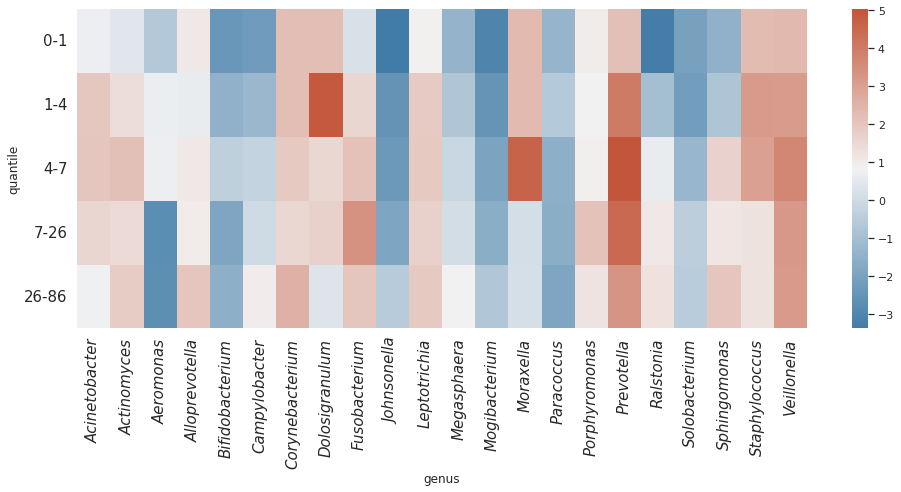

In [113]:
fig, ax = plt.subplots(nrows=1,
                               figsize=(14, 7))

sns.set(font_scale=1)
sns.heatmap(for_plots.T,
                    cmap=sns.diverging_palette(240,20,center='light',as_cmap=True),
                    ax = ax
                    )

font_props = FontProperties().copy()
font_props.set_size(15)

ax.set_yticklabels(ax.get_ymajorticklabels(), fontproperties=font_props)
font_props.set_style("italic")
ax.set_xticklabels(ax.get_xmajorticklabels(), fontproperties=font_props)


plt.yticks(rotation=0)
plt.tight_layout()

We can examine the resulting plots when ploting abundance againt age and using region as a color encoding for significant taxa.

In [ ]:
for taxon in results_age[results_age['q']<0.1].genus:
    plt = (ggplot(
    res_age[res_age.genus.str.contains(taxon)], aes(x = 'age', y = 'clr', color = 'region'))
    +geom_point()
    +geom_smooth(method = 'lm')
    +labs(x = 'Age', y = 'Centered Log Ratio', title = taxon, color = 'Continent'))
    print(plt)

In [ ]:
results = pd.DataFrame()
for taxon in res_metadata['genus'].unique():
    temp = res_metadata[res_metadata['genus'].str.startswith(taxon)]
    if min(temp.region.value_counts())<5: 
        temp = temp[~temp.region.str.contains(temp.region.value_counts()[temp.region.value_counts()<5].index[0])]
    md = smf.mixedlm("clr ~ age + sex + region",temp, groups=temp["sample_id"])
    mdf = md.fit()
    pval_age = mdf.pvalues['age']
    pval_sex = mdf.pvalues['sex[T.M]']
    results = pd.concat([results, pd.DataFrame({'genus':[taxon],'p_sex':[pval_sex],'p_age':[pval_age]})])

In [ ]:
results['q_sex']= fdrcorrection(results['p_sex'])[1]
results['q_age']= fdrcorrection(results['p_age'])[1]
results[results['q_age']<0.05]

In [ ]:
results = pd.DataFrame()
for taxon in res['genus'].unique():
    temp = res[res['genus'].str.startswith(taxon)]
    if min(temp.region.value_counts())<5: 
        temp = temp[~temp.region.str.contains(temp.region.value_counts()[temp.region.value_counts()<5].index[0])]
    md = smf.ols("clr ~ URT + region",temp)
    mdf = md.fit()
    # pval = mdf.pvalues[']
    # results_age = pd.concat([results_age, pd.DataFrame({'genus':[taxon],'p':[pval]})])

In [ ]:
mdf.summary()

In [ ]:
results_sex = pd.DataFrame()
for taxon in res_sex['genus'].unique():
    temp = res_sex[res_sex['genus'].str.startswith(taxon)]
    if min(temp.region.value_counts())<5: 
        temp = temp[~temp.region.str.contains(temp.region.value_counts()[temp.region.value_counts()<5].index[0])]
    md = smf.ols("clr ~ sex + URT + region + Study",temp)
    mdf = md.fit()
    pval = mdf.pvalues['sex[T.M]']
    results_sex = pd.concat([results_sex, pd.DataFrame({'genus':[taxon],'p':[pval]})])

In [ ]:
results_sex = results_sex.dropna(subset = ['p'])
results_sex['q']= fdrcorrection(results_sex['p'])[1]
results_sex[results_sex['q']<0.05].sort_values(by = 'q')


In [ ]:
results = pd.DataFrame()
for taxon in res['genus'].unique():
    temp = res[res['genus'].str.startswith(taxon)]
    if min(temp.region.value_counts())<5: 
        temp = temp[~temp.region.str.contains(temp.region.value_counts()[temp.region.value_counts()<5].index[0])]
    md = smf.ols("clr ~ URT + region + Study",temp)
    mdf = md.fit()
    anova_results = anova_lm(mdf)
    pval = anova_results['PR(>F)']['region']
    results = pd.concat([results, pd.DataFrame({'genus':[taxon],'p':[pval]})])

In [ ]:
results = results.dropna(subset = ['p'])
results['q']= fdrcorrection(results['p'])[1]
results[results['q']<0.05].sort_values(by = 'q')

In [ ]:
taxon = 'Moraxella'
temp = res[res['genus'].str.startswith(taxon)]
if min(temp.region.value_counts())<5: 
    temp = temp[~temp.region.str.contains(temp.region.value_counts()[temp.region.value_counts()<5].index[0])]
md = smf.ols("clr ~ URT + region + Study",temp)
mdf = md.fit()
anova_results = anova_lm(mdf)
pval = anova_results['PR(>F)']['region']
results = pd.concat([results, pd.DataFrame({'genus':[taxon],'p':[pval]})])

In [ ]:
from statsmodels.stats.anova import anova_lm
anova_results = anova_lm(mdf)


In [114]:
res_sex

,sample_id,full_taxonomy,reads,kingdom,phylum,class,order,family,genus,relative,condition,region,country,URT,Study,age,sex,clr
0,ERR1978216,Bacteria|Firmicutes|Bacilli|Lactobacillales|St...,24951.0,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,0.816353,control,Europe,Netherlands,NP,PRJEB20811,0.139726,M,8.768478
2,ERR1978216,Bacteria|Actinobacteriota|Actinobacteria|Coryn...,12.0,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Corynebacterium,0.000393,control,Europe,Netherlands,NP,PRJEB20811,0.139726,M,-2.194505
3,ERR1978216,Bacteria|Firmicutes|Bacilli|Staphylococcales|S...,7.0,Bacteria,Firmicutes,Bacilli,Staphylococcales,Staphylococcaceae,Staphylococcus,0.000229,control,Europe,Netherlands,NP,PRJEB20811,0.139726,M,-2.931470
4,ERR1978216,Bacteria|Proteobacteria|Gammaproteobacteria|Bu...,127.0,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,0.004155,control,Europe,Netherlands,NP,PRJEB20811,0.139726,M,1.155993
5,ERR1978216,Bacteria|Firmicutes|Bacilli|Staphylococcales|G...,816.0,Bacteria,Firmicutes,Bacilli,Staphylococcales,Gemellaceae,Gemella,0.026698,control,Europe,Netherlands,NP,PRJEB20811,0.139726,M,3.834948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,SRR501807,Bacteria|Fusobacteriota|Fusobacteriia|Fusobact...,24.0,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Leptotrichia,0.000561,control,Europe,Denmark,OP,SRP013435,24.000000,F,-1.648895
821,SRR501807,Bacteria|Proteobacteria|Gammaproteobacteria|Ps...,6.0,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Moraxella,0.000140,control,Europe,Denmark,OP,SRP013435,24.000000,F,-3.563165
822,SRR501807,Bacteria|Synergistota|Synergistia|Synergistale...,18.0,Bacteria,Synergistota,Synergistia,Synergistales,Synergistaceae,Fretibacterium,0.000421,control,Europe,Denmark,OP,SRP013435,24.000000,F,-2.054151
823,SRR501807,Bacteria|Firmicutes|Clostridia|Clostridia_vadi...,41.0,Bacteria,Firmicutes,Clostridia,Clostridia_vadinBB60_group,Clostridia_vadinBB60_group,Clostridia_vadinBB60_group,0.000958,control,Europe,Denmark,OP,SRP013435,24.000000,F,-0.888565


In [117]:
results_sex = pd.DataFrame()
for taxon in res_sex['genus'].unique():
    temp = res_sex[res_sex['genus'].str.startswith(taxon)]
    if min(temp.region.value_counts())<5: 
        temp = temp[~temp.region.str.contains(temp.region.value_counts()[temp.region.value_counts()<5].index[0])]
    md = smf.ols("clr ~ sex + URT + region",temp)
    mdf = md.fit()
    pval = mdf.pvalues['sex[T.M]']
    results_sex = pd.concat([results_sex, pd.DataFrame({'genus':[taxon],'p':[pval]})])
results_sex

,genus,p
0,Streptococcus,0.701065
0,Corynebacterium,0.015801
0,Staphylococcus,0.233634
0,Achromobacter,0.915011
0,Gemella,0.672079
...,...,...
0,Caulobacter,0.775851
0,Herbaspirillum,0.888697
0,Taonella,0.501339
0,Azorhizobium,0.602129


In [120]:
results_sex = results_sex.dropna(subset = ['p'])
results_sex['q']= fdrcorrection(results_sex['p'])[1]
results_sex[(results_sex['q']<0.05)]
results_sex['genus'] = results_sex['genus'].str.split('_').str[0]
results_sex.sort_values(by = 'q')

,genus,p,q
0,Mitochondria,0.003033,0.299083
0,RF39,0.003036,0.299083
0,Phreatobacter,0.015360,0.518789
0,Corynebacterium,0.015801,0.518789
0,Parabacteroides,0.008186,0.518789
...,...,...,...
0,Microbacterium,0.963392,0.993509
0,Bilophila,0.979261,0.993509
0,JGI,0.988032,0.993509
0,Parasutterella,0.988352,0.993509
